In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%pip install pandas
import pandas as pd

class Rect:
    def __init__(self, bottom_left, top_right):
        assert bottom_left[0] < top_right[0]
        assert bottom_left[1] < top_right[1]
        self._bl = bottom_left
        self._tr = top_right

    @property
    def bottom_left(self):
        return self._bl

    @property
    def top_right(self):
        return self._tr
    
    @property
    def bottom_right(self):
        return np.array([self._tr[0], self._bl[1]])
    
    @property
    def top_left(self):
        return np.array([self._bl[0], self._tr[1]])

    @property
    def center(self):
        return (self._bl + self._tr) / 2

    @property
    def w(self):
        return (self._tr - self._bl)[0]

    @property
    def h(self):
        return (self._tr - self._bl)[1]
    
    @property
    def xy(self):
        return (self._bl[0], self._bl[1])

    @property
    def area(self):
        return self.w * self.h

    def draw(self, ax, edgecolor='black', color=None, alpha=1.0):
        rect = patches.Rectangle(self.xy, self.w, self.h, linewidth=1, edgecolor=edgecolor, facecolor=color, alpha=alpha)
        ax.add_patch(rect)
    
    @staticmethod
    def make(x=None, y=None, w=None, h=None, bottom_left=None, top_right=None, top_left=None, bottom_right=None):
        if x and y and w and h:
            return Rect(np.array([x, y]), np.array([x + w, y + h]))
        elif bottom_left is not None and top_right is not None:
            return Rect(bottom_left, top_right)
        elif top_left is not None and bottom_right is not None:
            bl = np.array([top_left[0],bottom_right[1]])
            tr = np.array([bottom_right[0],top_left[1]])
            return Rect(bl, tr)

def pt(x, y):
    return np.array([x, y])


Note: you may need to restart the kernel to use updated packages.


East
Panels: 15
area(m^2): 25.126982004000002
nominal power(watts): 5475
West
Panels: 20
area(m^2): 33.502642672
nominal power(watts): 7300


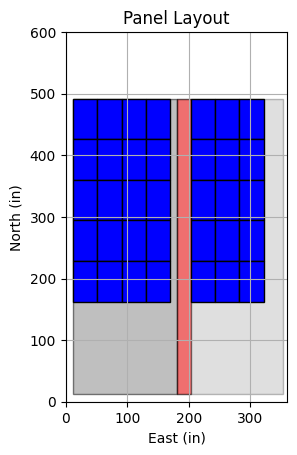

In [44]:
ft=12

east_estimates = pd.read_csv("monthly-east.csv")

west_estimates = pd.read_csv("monthly-west.csv")
usage = pd.read_csv("usage.csv")

def layout_panels(bbox, panel_w, panel_h):
    panels = []
    panel_dims = pt(panel_w, panel_h)
    for c in range(int(bbox.w / panel_w)):
        for r in range(int(bbox.h / panel_h)):
            panels.append(Rect.make(
                top_left=bbox.top_left + panel_dims * pt(c, -r), 
                bottom_right=bbox.top_left + panel_dims * pt(c+1, -(r+1))
            ))
    return panels

west_roof_dims = pt(14*ft + 5, 40 * ft)
east_roof_dims = pt(14*ft + 5, 40 * ft)

anual_ppp_west = west_estimates["AC System Output (kWh)"] / 12
anual_ppp_east = east_estimates["AC System Output (kWh)"] / 9

# panel_w, panel_h = 77, 39
panel_w, panel_h = 66, 39
panel_w, panel_h = 65.9, 39.4
panel_watts = 365
# panel_w, panel_h = 39, 77
panel_dims = pt(panel_w, panel_h)

# Compute roof zone bounds 
west_roof = Rect.make(x=1 * ft, y=1 * ft, w=14 * ft, h=40 * ft)
east_roof = Rect.make(top_left=west_roof.top_right, bottom_right=west_roof.top_right+east_roof_dims * pt(1, -1))
east_vents = Rect.make(x=east_roof.bottom_left[0], y=east_roof.bottom_left[1], w=east_roof.w-(12*ft + 6), h=40*ft)

# compute areas where panels can be placed
west_panel_footprint = Rect.make(top_left=west_roof.top_left, bottom_right=west_roof.bottom_right + pt(0, 10 * ft))
east_panel_footprint = Rect.make(top_left=east_vents.top_right, bottom_right=east_roof.bottom_right + pt(0, 10 * ft))

# layout panels
west_panels = layout_panels(west_panel_footprint, panel_h, panel_w)
east_panels = layout_panels(east_panel_footprint, panel_h, panel_w)

# Example usage:
fig, ax = plt.subplots()

## Draw the roof and layout
west_roof.draw(ax, color='grey', alpha=0.5)
east_roof.draw(ax, color='grey', alpha=0.25)
east_vents.draw(ax, color='red', alpha=0.5)

for panel in west_panels + east_panels:
    panel.draw(ax, color='blue')

def stats(region, panels):
    area_sq_in = 0
    for p in panels:
        area_sq_in += p.area
    print(region)
    print(f'Panels: {len(panels)}')
    print(f'area(m^2): {area_sq_in * 0.00064516}')
    print(f'nominal power(watts): {len(panels) * panel_watts}')

stats('East', east_panels)
stats('West', west_panels)

plt.xlabel('East (in)')
plt.ylabel('North (in)')
ax.set_xlim(0, 30 * 12)  # Setting x-axis bounds
ax.set_ylim(0, 50 * 12)  # Setting y-axis bounds

plt.title('Panel Layout')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
plt.show()

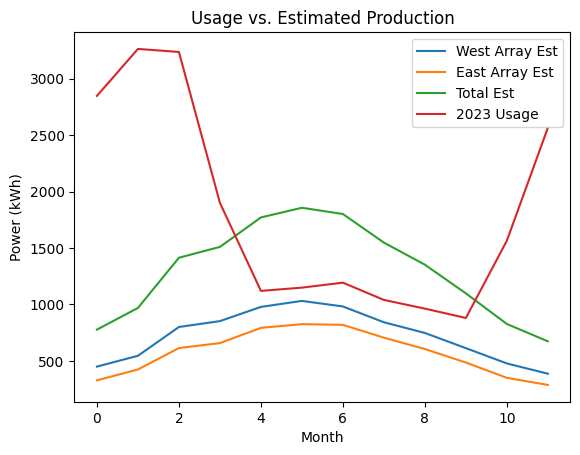

Total consumption in 2023: 21724.0 kWh
Net power: -6127.288333333334 kWh/year
Cost: -878.0404181666668


In [45]:
# Example usage:
fig, ax = plt.subplots()
plt.xlabel('Month')
plt.ylabel('Power (kWh)')
plt.title('Usage vs. Estimated Production')
power_east = anual_ppp_east * len(east_panels)
power_west = anual_ppp_west * len(west_panels)

ax.plot(power_west, label="West Array Est")
ax.plot(power_east, label="East Array Est")
ax.plot(power_east + power_west, label="Total Est")
ax.plot(usage["Usage(Real energy in kilowatt-hours)"], label="2023 Usage")
plt.legend()
plt.show()
print(f'Total consumption in 2023: {sum(usage["Usage(Real energy in kilowatt-hours)"])} kWh')

net_power = (power_west + power_east) - usage["Usage(Real energy in kilowatt-hours)"]
print(f'Net power: {np.sum(net_power)} kWh/year')
print(f'Cost: {np.sum(net_power) * 0.1433}')